Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Neural Style Transfer/Images

/content/drive/MyDrive/Neural Style Transfer/Images


Importing the necessary libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
import cv2
from google.colab.patches import cv2_imshow

Checking the dimensions of the images



In [55]:
original_image_path = "../Images/nebraska_rural.jpg"
original_img = cv2.imread(original_image_path)
print(original_img.shape)
style_image_path = "../Images/kanagawa_wave.jpg"
style_img = cv2.imread(style_image_path)
print(style_img.shape)

(183, 276, 3)
(184, 274, 3)


Original and Style Image

Original Image: 


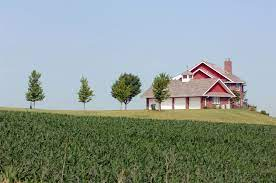

Style Image: 


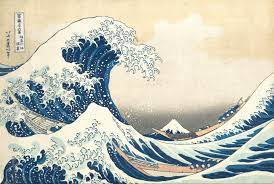

In [56]:
print("Original Image: ")
cv2_imshow(original_img)
print("Style Image: ")
cv2_imshow(style_img)

Function to load and resize the image (We have loaded the images above already, but putting it all together in a function for convenience) 



In [57]:
def load_img(im_path):

  max_dim = 512
  img = Image.open(im_path)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

  img = tf.keras.preprocessing.image.img_to_array(img)

    # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img


Data Preprocessing

In [58]:
def img_preprocessing(img_loc):
  img = load_img(img_loc) 
  pre_img = preprocess_input(img)
  return pre_img

In [59]:
pre_img = img_preprocessing(style_image_path) 

In [60]:
pre_img.shape

(1, 344, 512, 3)

Deprocessing (A brief description about the removal of zero centering: https://stackoverflow.com/questions/64115145/keras-style-transfer-remove-zero-center-by-mean-pixel)

In [61]:
def img_deprocessing(proc_img):
  x = proc_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("ok")
  if len(x.shape) != 3:
    raise ValueError("Invalid input")
  #Removing zero-centering
  proc_img[:,:,0] += 103.939
  proc_img[:,:,1] += 116.779
  proc_img[:,:,2] += 123.68
  proc_img = cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB)
  proc_img = np.clip(proc_img, 0, 255).astype("uint8") 
  return proc_img

We use the hidden (intermediate) layers to map the features. We use deeper layers to capture highly detailed features of our original image. Shallow layers are used to capture features which are of less detail in our style image, as our original image is supposed to be more dominant than the style image.

In [62]:
original_img_layers = ['block5_conv2',
                       'block4_conv2',
                       'block4_conv4']
style_img_layers = ['block1_conv1',
                    'block2_conv1',
                    'block3_conv1', 
                    'block4_conv1', 
                    'block5_conv1'
                   ]

Loading the pretrained model (VGG19)

In [63]:
def load_model():
  model = VGG19(include_top=False, weights='imagenet')
  model.trainable = False

  #Putting the respective output layers into lists
  original_output = []
  style_output = []
  for layer_name in original_img_layers:
    t = model.get_layer(layer_name).output 
    original_output.append(t)
  for layer_name in style_img_layers:
    t = model.get_layer(layer_name).output
    style_output.append(t)
  model_output = style_output + original_output
  vgg_model = models.Model(model.input, model_output)
  return vgg_model

In [64]:
vgg_model = load_model() 

In [65]:
vgg_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

Setting model.trainable as True would give us 15,304,768 **trainable** parameters

Content Loss

In [66]:
def original_loss(base,target):
  c_loss = tf.reduce_mean(tf.square(base-target))
  return c_loss

Gram Matrix

In [67]:
def gram_matrix(input):
  channels = input.shape[-1]
  if type(channels) is not int:
    channels = int(channels)
  a = tf.reshape(input, [-1, channels])
  b = tf.shape(a)[0]
  gram_mat = tf.matmul(a,a,transpose_a=True)
  return gram_mat / tf.cast(b, tf.float32)

Style Loss

In [68]:
def style_loss(base, target):
  temp = base.get_shape()
  h,w,c = temp.as_list()
  gram_style = gram_matrix(base) 
  
  s_loss = tf.reduce_mean(tf.square(gram_style-target))
  return s_loss

In [69]:
def get_features(model, o_loc, s_loc):
  original_img = img_preprocessing(original_image_path)
  style_img = img_preprocessing(style_image_path) 

  original_output = vgg_model(original_img)
  style_output = vgg_model(style_img) 

  features_original = []
  features_style = []
  for layer in original_output[5:]:
    temp = layer[0]
    features_original.append(temp)
  for layer in style_output[:5]:
    temp = layer[0]
    features_style.append(temp) 
  
  return features_style, features_original

Total Loss

In [91]:
def total_loss(model, loss_weights, init_image, gram_style_feat, original_features):
  style_weight, original_weight = loss_weights
  model_output = model(init_image)

  style_output_features = model_output[:5]
  original_output_features = model_output[5:]

  style_score = 0
  original_score = 0

  wt_per_style_layer = 1.0/5.0
  for target_style, comb_style in zip(gram_style_feat, style_output_features):
    style_score += wt_per_style_layer * style_loss(comb_style[0], target_style)
  
  wt_per_original_layer = 1.0/3.0
  for target_original, comb_original in zip(original_features, original_output_features):
    original_score += wt_per_original_layer* original_loss(comb_original[0], target_original)
  
  style_score *= style_weight
  original_score *= original_weight

  loss = style_score + original_score
  return loss, style_score, original_score

Gradients

In [95]:
def grads(x):
  with tf.GradientTape() as tape:
    all_loss = total_loss(**x)

  full_loss = all_loss[0]
  return tape.gradient(full_loss, x['init_image']), all_loss

Style Transfer

In [96]:
import time
import IPython.display
def style_transfer(original_path, style_path, num_iterations=10000, original_weight=1e3, style_weight=1e-2): 

  model = load_model() 
  for layer in model.layers:
    layer.trainable = False
  
  style_features, original_features = get_features(model, original_path, style_path)
  gram_style_feat = [gram_matrix(style_feature) for style_feature in style_features]
  
  init_image = img_preprocessing(original_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  opt = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
  iter_count = 1
  
  best_loss, best_img = float('inf'), None
  
  loss_weights = (style_weight, original_weight)
  x = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_feat': gram_style_feat,
      'original_features': original_features
  }
    
  # For displaying
  
  display_interval = 10
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grad, all_loss = grads(x)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grad, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    print("=",end=" ")
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = img_deprocessing(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = img_deprocessing(plot_img)
      imgs.append(plot_img)
      #IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('\nIteration: {}'.format(i))        
      print('Total loss: {:.4f}, ' 
            'style loss: {:.4f}, '
            'original loss: {:.4f}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
 
  return best_img, best_loss

In [ ]:
best, best_loss = style_transfer(original_image_path, style_image_path, num_iterations=200)